In [12]:
import glob
import torch


In [13]:
#H_init, lr_H, T, lambda_scale_factor = 'uniformones_FourierBased', '0.0', '1', '7'
H_init, lr_H, T, lambda_scale_factor = 'randn_FourierBased', '1.0', '4', '8'


#H_init, lr_H, T, lambda_scale_factor = 'randn_FourierBased', '1.0', '4', '7'
#H_init, lr_H, T, lambda_scale_factor = 'uniformones_FourierBased', '0.0', '1', '6'

#H_init, lr_H, T, lambda_scale_factor = 'randn_FourierBased', '1.0', '4', '6'
#H_init, lr_H, T, lambda_scale_factor = 'uniformones_FourierBased', '0.0', '1', '5'


exp_dir =  f'/n/holylfs/LABS/wadduwage_lab/Lab/uom_Udith/results/aim2/figs_cvpr_segmentation/set1/name(confocal)@rotation_lambda(10000.0)@lambda_scale_factor({lambda_scale_factor})@T({T})@img_size(256)@num_samples_train(3000)@upsample_net(custom_v2)@H_init({H_init})@lr_H({lr_H})'
glob.glob(f'{exp_dir}/save_special/*.pth')

['/n/holylfs/LABS/wadduwage_lab/Lab/uom_Udith/results/aim2/figs_cvpr_segmentation/set1/name(confocal)@rotation_lambda(10000.0)@lambda_scale_factor(8)@T(4)@img_size(256)@num_samples_train(3000)@upsample_net(custom_v2)@H_init(randn_FourierBased)@lr_H(1.0)/save_special/latest_model.pth']

In [14]:
model_dir = glob.glob(f'{exp_dir}/save_special/*.pth')[0]

In [15]:
model_info= torch.load(model_dir)
cfg= model_info['cfg']

decoder_upsample_state_dict= model_info['decoder_upsample']
decoder_state_dict= model_info['decoder']
model_H_state_dict= model_info['model_H']
m = model_info['m']
epoch = model_info['epoch']

In [16]:
import sys
sys.path.append('../')

import torch
import glob
from torch import nn
import shutil
import os
from contextlib import redirect_stdout
from defaults import get_cfg_defaults

from modules.models.preprocess_H_weights import * #ifft_2d_with_fftshift_real
from modules.custom_activations import sigmoid_custom
from modules.kernels import *

from modules.datasets import *
from modules.data_utils import return_dataloaders

from modules.train_utils.segmentation import train

from modules.models.forward_model import modelA_class
from modules.models.forward_H import modelH_class
from modules.models.decoder import *
from modules.models.decoder_upsampling_nets import *
from modules.models.decoder_upsampling_nets_experimental import *
from modules.models.decoder_support_blocks import conv_bn_block
from modules.m_inc_procs import *

from modules.models.lambdat_yt_skips import *

#general params
torch_seed= cfg.GENERAL.torch_seed
device = cfg.GENERAL.device
save_dir= cfg.GENERAL.save_dir

#dataset params
get_dataset_func= eval(cfg.DATASET.name)
img_size= cfg.DATASET.img_size
num_samples_train= cfg.DATASET.num_samples_train
delta=cfg.DATASET.delta
batch_size_train= cfg.DATASET.batch_size_train
img_channels= cfg.DATASET.img_channels

# train params:
epochs=cfg.TRAIN.epochs
m_inc_proc =  eval(cfg.TRAIN.m_inc_proc)
show_results_epoch= cfg.TRAIN.show_results_epoch
train_model_iter= cfg.TRAIN.train_model_iter
train_H_iter= cfg.TRAIN.train_H_iter
criterion= eval(cfg.TRAIN.criterion) # defined below after defining models
classifier=cfg.TRAIN.classifier
rescale_for_classifier=cfg.TRAIN.rescale_for_classifier

## params to H:
T= cfg.MODEL.MODEL_H.T
H_weight_preprocess= eval(cfg.MODEL.MODEL_H.H_weight_preprocess)
H_init = cfg.MODEL.MODEL_H.H_init
initialization_bias= cfg.MODEL.MODEL_H.initialization_bias
H_activation= eval(cfg.MODEL.MODEL_H.H_activation)
lr_H= cfg.MODEL.MODEL_H.lr_H

## params to A
sPSF= eval(cfg.MODEL.MODEL_A.sPSF)
exPSF= eval(cfg.MODEL.MODEL_A.exPSF)

noise=cfg.MODEL.MODEL_A.noise
lambda_scale_factor=cfg.MODEL.MODEL_A.lambda_scale_factor # downsample
rotation_lambda=cfg.MODEL.MODEL_A.rotation_lambda
shift_lambda_real=cfg.MODEL.MODEL_A.shift_lambda_real

readnoise_std=cfg.MODEL.MODEL_A.readnoise_std

## decoder params:
decoder_name= eval(cfg.MODEL.MODEL_DECODER.name)
upsampling_net_name = eval(cfg.MODEL.MODEL_DECODER.upsample_net)
custom_upsampling_bias= cfg.MODEL.MODEL_DECODER.custom_upsampling_bias
decoder_upsample_init_method= cfg.MODEL.MODEL_DECODER.upsample_net_init_method
channel_list=cfg.MODEL.MODEL_DECODER.channel_list
lr_decoder= cfg.MODEL.MODEL_DECODER.lr_decoder
last_activation=cfg.MODEL.MODEL_DECODER.last_activation #'sigmoid'

connect_forward_inverse= eval(cfg.MODEL.MODEL_DECODER.connect_forward_inverse)
print(f'skip connection between FORWARD and INVERSE models :: {cfg.MODEL.MODEL_DECODER.connect_forward_inverse}')
########################################################################

if lr_H==0:enable_train= False
else:enable_train=True

skip connection between FORWARD and INVERSE models :: no_skips


In [17]:
modelH = modelH_class(T=T, img_size = img_size, preprocess_H_weights= H_weight_preprocess, 
                          device = device, 
                          initialization_bias=initialization_bias, 
                          activation = H_activation, init_method= H_init, 
                          enable_train=enable_train, lambda_scale_factor= lambda_scale_factor).to(device)
    
modelA= modelA_class(sPSF= sPSF.to(device), exPSF= exPSF.to(device), noise=noise, device = device, 
                         scale_factor=lambda_scale_factor, rotation_lambda=rotation_lambda, 
                         shift_lambda_real= shift_lambda_real,
                         readnoise_std= readnoise_std)
    
if T!=1:
    upsample_postproc_block= nn.Sequential(conv_bn_block(in_channels= 1, out_channels= T//2, kernel_size= 3, padding= 1, stride=1),
                                           conv_bn_block(in_channels= T//2, out_channels= T, kernel_size= 3, padding= 1, stride=1))
else:
    upsample_postproc_block= nn.Sequential(conv_bn_block(in_channels= 1, out_channels= T, kernel_size= 3, padding= 1, stride=1),
                                           conv_bn_block(in_channels= T, out_channels= T, kernel_size= 3, padding= 1, stride=1))

decoder_upsample_net= upsampling_net_name(lambda_scale_factor= lambda_scale_factor, T= T, recon_img_size= img_size, init_method= decoder_upsample_init_method, Ht= modelH(m=1).detach(), custom_upsampling_bias= custom_upsampling_bias, upsample_postproc_block= upsample_postproc_block)
    
if decoder_upsample_net.__class__.__bases__[0]== nn.modules.module.Module:
    decoder_upsample_net= decoder_upsample_net.to(device)

decoder= decoder_name(T, img_size, img_channels, channel_list, last_activation).to(device)


In [18]:
decoder_upsample_net.load_state_dict(decoder_upsample_state_dict)
decoder.load_state_dict(decoder_state_dict)
modelH.load_state_dict(model_H_state_dict)

decoder_upsample_net.eval()
decoder.eval()
modelH.eval()

print('loading successful !!!')

loading successful !!!


total images found in: /n/holylfs/LABS/wadduwage_lab/Lab/uom_Udith/datasets/confocal/63xZseriesSmall_w1//train -> 13608
total images found in: /n/holylfs/LABS/wadduwage_lab/Lab/uom_Udith/datasets/confocal/63xZseriesSmall_w1//val -> 1701
total images found in: /n/holylfs/LABS/wadduwage_lab/Lab/uom_Udith/datasets/confocal/63xZseriesSmall_w1//test -> 1701
dataset lenths : 3000 | 1701 | 1701


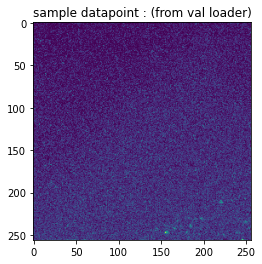

In [19]:
trainset, valset, testset = get_dataset_func(img_size= img_size, delta= delta, num_samples_train= num_samples_train)
train_loader, val_loader, test_loader = return_dataloaders(trainset, valset, testset, batch_size_train= batch_size_train, drop_last_val_test= False)

In [20]:
from modules.tasks import segment
from modules.eval_metrics import ssim_ignite, mse_distance
import cv2

def iou(X_hat, X):return 0
def dice_score(X_hat, X):return 0

dataset value range :  1.0000001111620804e-06 1.0


In [21]:
def iou(X_hat, X):
    X_hat= (X_hat>0.5).int()
    X= X.int()
    
    SMOOTH = 1e-6
    outputs = X_hat.squeeze(1)  # BATCH x 1 x H x W => BATCH x H x W
    labels = X.squeeze(1)  # BATCH x 1 x H x W => BATCH x H x W

    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0    
    return iou.mean().item()


def dice_score(X, X_hat, smooth=1):
    #https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2#:~:text=Simply%20put%2C%20the%20Dice%20Coefficient,of%20pixels%20in%20both%20images.&text=They%20are%20positively%20correlated%2C%20meaning,other%20will%20say%20the%20same.
    y_pred= (X_hat>0.5).int()
    y_true= X.int()    

    intersection = torch.sum(y_true * y_pred, axis=[1,2,3])
    union = torch.sum(y_true, axis=[1,2,3]) + torch.sum(y_pred, axis=[1,2,3])
    dice = torch.mean((2. * intersection + smooth)/(union + smooth), axis=0)
    return dice.item()

In [ ]:
losses_temp = []
metric_ssim11_temp = []
metric_ssim5_temp = []
metric_mse_temp = []

metric_iou_temp = []
metric_dice_temp = []

for i, (x, y) in enumerate(val_loader):
    x= x.to(device)
    y= y.to(device)

    decoder_upsample_net.eval()
    decoder.eval()
    modelH.eval()

    with torch.no_grad():
        X= x.float()
        Ht= modelH(m)

        lambda_up, yt_down = modelA.compute_yt(X, Ht)
        yt_up = decoder_upsample_net(yt_down, Ht= Ht) + connect_forward_inverse(lambda_up, epoch)
        X_hat = decoder(yt_up, Ht= Ht) # Ht will be used if Ht should be updated through decoder, Therefore depend on the decoder architecture

    if i==0:
        gt_seg = segment(X)
        pred_seg = X_hat
        gt_img= X
    else:
        gt_seg = torch.cat((gt_seg, segment(X)), dim=0)
        pred_seg = torch.cat((pred_seg, X_hat), dim=0)
        gt_img = torch.cat((gt_img, X), dim=0)
        
    metric_ssim11_temp.append(ssim_ignite((X_hat > 0.5).float(), segment(X), k=11))
    metric_ssim5_temp.append(ssim_ignite((X_hat > 0.5).float(), segment(X), k=5))
    metric_mse_temp.append(mse_distance((X_hat > 0.5).float(), segment(X)))
    
    metric_iou_temp.append(iou((X_hat > 0.5).float(), segment(X)))
    metric_dice_temp.append(dice_score((X_hat > 0.5).float(), segment(X)))

    
print(f'ssim11 : {np.mean(metric_ssim11_temp)}')
print(f'ssim5  : {np.mean(metric_ssim5_temp)}')
print(f'mse    : {np.mean(metric_mse_temp)}')

print(f'iou    : {np.mean(metric_iou_temp)}')
print(f'dice   : {np.mean(metric_dice_temp)}')


plt.figure()
plt.subplot(1,2,1)
plt.imshow(cv2.rotate((X.detach().cpu()[5,0]*255.0).numpy().astype('uint8'), cv2.cv2.ROTATE_90_CLOCKWISE))
plt.subplot(1,2,2)
plt.imshow(cv2.rotate((X_hat.detach().cpu()[5,0]*255.0).numpy().astype('uint8'), cv2.cv2.ROTATE_90_CLOCKWISE))
plt.suptitle('img put into the paper')
plt.show()

In [ ]:
import cv2

gt_seg = gt_seg.cpu()
pred_seg = pred_seg.cpu()
gt_img = gt_img.cpu()

plt.figure(figsize= (14, 14))
plt.subplot(2,2,1)
grid_img1 = torchvision.utils.make_grid(gt_seg[:100], nrow=10)
plt.imshow(cv2.cvtColor(grid_img1.permute(1,2,0).numpy(), cv2.COLOR_RGB2GRAY))
plt.title('gt')

plt.subplot(2,2,2)
grid_img2 = torchvision.utils.make_grid(pred_seg[:100], nrow=10)
plt.imshow(cv2.cvtColor(grid_img2.permute(1,2,0).numpy(), cv2.COLOR_RGB2GRAY))
plt.title('pred')

plt.subplot(2,2,3)
grid_img3 = torchvision.utils.make_grid(gt_img[:100], nrow=10)
plt.imshow(cv2.cvtColor(grid_img3.permute(1,2,0).numpy(), cv2.COLOR_RGB2GRAY))
plt.title('gt image')
plt.show()

In [22]:
from PIL import Image
import torchvision

transform = torchvision.transforms.Compose([
                                    torchvision.transforms.Grayscale(1),
                                    torchvision.transforms.ToTensor(),
                                    torchvision.transforms.Normalize((0,), (1,))])
            
def whole2patch(whole_img, H, W, img_size): #whole_img: (H, W), patch_imgs: (b, 1, img_size, img_size)
    patch_imgs = whole_img.reshape(H//img_size, img_size, W//img_size, img_size).permute(0, 2, 1, 3).flatten(start_dim=0, end_dim=1).unsqueeze(dim=1)
    return patch_imgs

def patch2whole(patch_imgs, H, W, img_size): # patch_imgs: (b, 1, img_size, img_size)
    out_recon= patch_imgs[:,0].reshape(H//img_size, W//img_size, img_size, img_size).permute(0, 2, 1, 3).flatten(start_dim=0, end_dim=1).flatten(start_dim=1, end_dim=2)
    return out_recon

def pad_img(img, window_size, h_old, w_old): # input: img (A, B)
    h_pad = (h_old // window_size + 1) * window_size - h_old
    w_pad = (w_old // window_size + 1) * window_size - w_old
    img = torch.cat([img, torch.flip(img, [0])], 0)[:h_old + h_pad, :]
    img = torch.cat([img, torch.flip(img, [1])], 1)[:, :w_old + w_pad]

    return img

def get_preds_decoder(decoder_upsample_net, decoder, modelH, X):
    decoder_upsample_net.eval()
    decoder.eval()
    modelH.eval()

    with torch.no_grad():
        Ht= modelH(m)
        lambda_up, yt_down = modelA.compute_yt(X, Ht)
        yt_up = decoder_upsample_net(yt_down, Ht= Ht)
        X_hat = decoder(yt_up, Ht= Ht) # Ht will be used if Ht should be updated through decoder, Therefore depend on the decoder architecture
        
    return X_hat, Ht, yt_down

In [23]:
import matplotlib.pyplot as plt
import glob

In [24]:
import matplotlib.pyplot as plt
import glob
import numpy as np

In [25]:
imgs=[]

img_no= 169
i=0
for img_dir in sorted(glob.glob(f"/n/holylfs/LABS/wadduwage_lab/Lab/uom_Udith/datasets/confocal_w1_segmentation_dataset/val/images/*s{img_no}*"), key= lambda x:-int(x[:-4].split('_')[-1])):
    i+=1
    if i>13:break
    #print(int(img_dir[:-4].split('_')[-1]))
    imgs = [plt.imread(img_dir)] + imgs

imgs= np.array(imgs)
imgs = np.concatenate([imgs[:4], imgs[9:13]], axis=0)

In [26]:
import torch

In [27]:
window_size= 256
img_size= 256


img_dir= 'large_cell_imgs/63xZseriesSmallw1cells_sample_large_imgs/16.png' #94.png
input_img = transform(Image.fromarray((255*plt.imread(img_dir)).astype('uint8')))[0]
H, W = input_img.shape
input_img_padded = pad_img(input_img, window_size, H, W)
H_new, W_new = input_img_padded.shape

X= whole2patch(input_img_padded, H_new, W_new, img_size).to(device)

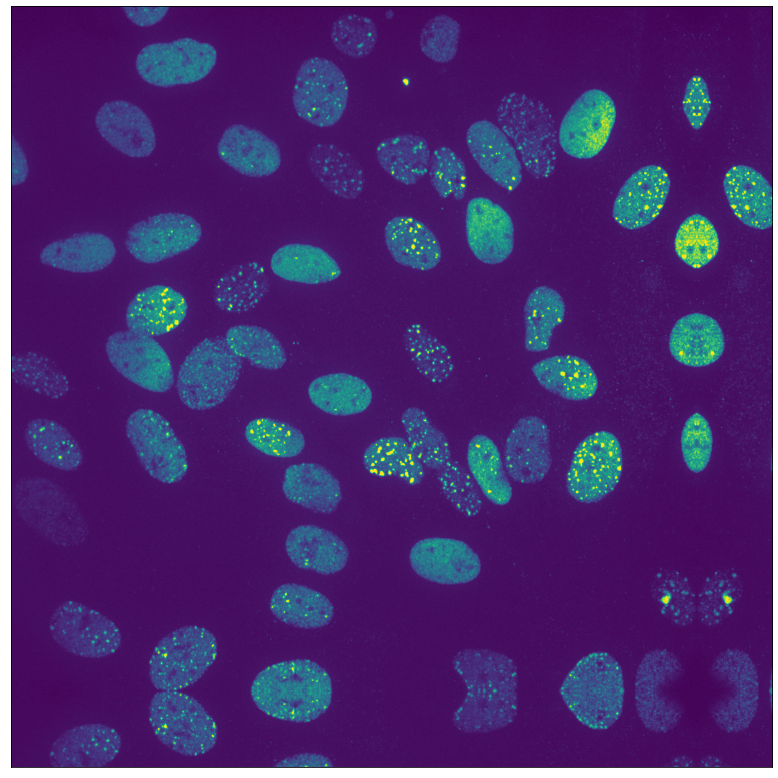

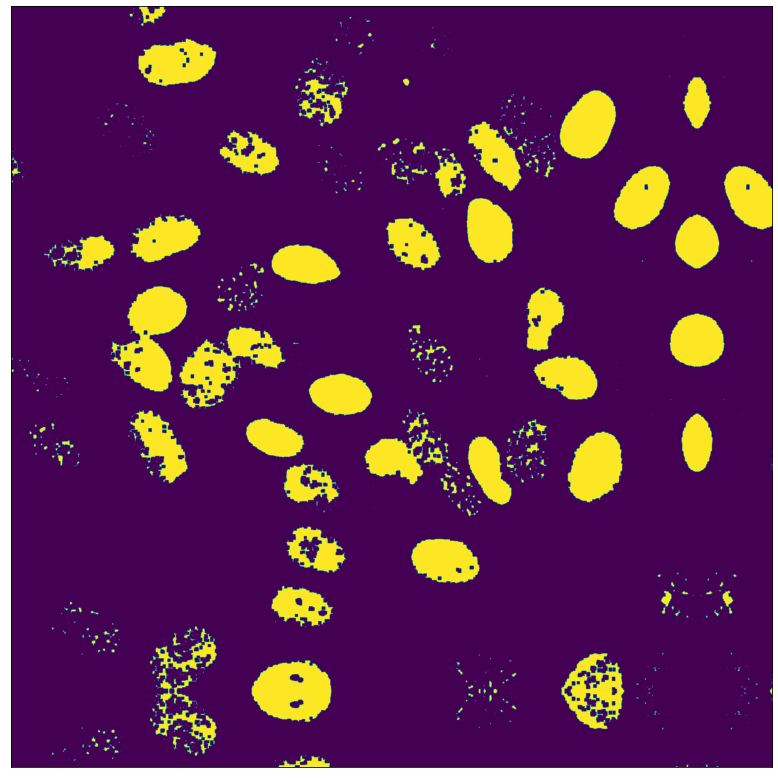

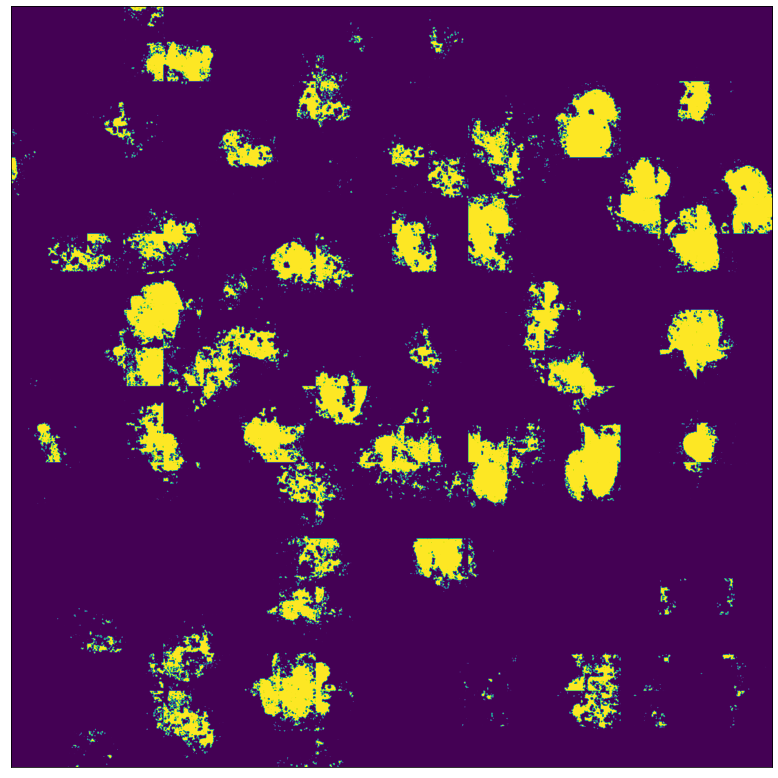

In [47]:
#X= torch.from_numpy(imgs).unsqueeze(dim=1).to(device)
Ht= modelH(m)
lambda_up, yt_down = modelA.compute_yt(X, Ht)
yt_up = decoder_upsample_net(yt_down, Ht= Ht)
X_hat = decoder(yt_up, Ht= Ht) # Ht will be used if Ht should be updated through decoder, Therefore depend on the decoder architecture
recon_img_padded = patch2whole(X_hat, H_new, W_new, img_size)
recon_img= recon_img_padded.detach().cpu()


plt.figure(figsize= (14, 14))
plt.imshow(patch2whole(X, H_new, W_new, img_size).detach().cpu())
plt.xticks([])
plt.yticks([])
#plt.savefig(f'./{i}_cellSR_baseline.png', dpi= 300)
plt.show()

plt.figure(figsize= (14, 14))
plt.imshow(segment(patch2whole(X, H_new, W_new, img_size).detach().cpu().unsqueeze(dim=0).unsqueeze(dim=0))[0,0])
plt.xticks([])
plt.yticks([])
#plt.savefig(f'./{i}_cellSR_baseline.png', dpi= 300)
plt.show()

plt.figure(figsize= (14, 14))
plt.imshow(recon_img)
plt.xticks([])
plt.yticks([])
#plt.savefig(f'./{i}_cellSR_baseline.png', dpi= 300)
plt.show()

In [28]:
img_dir= 'large_cell_imgs/63xZseriesSmallw1cells_sample_large_imgs/16.png' #94.png
input_img = transform(Image.fromarray((255*plt.imread(img_dir)).astype('uint8')))[0]
H, W = input_img.shape
input_img_padded = pad_img(input_img, window_size, H, W)
H_new, W_new = input_img_padded.shape
X= whole2patch(input_img_padded, H_new, W_new, img_size).to(device)

#X= next(iter(val_loader))[0].to(device)


In [29]:
import glob
import torch
import matplotlib.pyplot as plt
import numpy as np

device= 'cuda:0'

/n/holylfs/LABS/wadduwage_lab/Lab/uom_Udith/datasets/confocal/63xZseriesSmall_w1/val/63X_IF4small_1_w1640bp_s169_10.png
/n/holylfs/LABS/wadduwage_lab/Lab/uom_Udith/datasets/confocal/63xZseriesSmall_w1/val/63X_IF4small_1_w1640bp_s169_11.png
/n/holylfs/LABS/wadduwage_lab/Lab/uom_Udith/datasets/confocal/63xZseriesSmall_w1/val/63X_IF4small_1_w1640bp_s169_12.png
/n/holylfs/LABS/wadduwage_lab/Lab/uom_Udith/datasets/confocal/63xZseriesSmall_w1/val/63X_IF4small_1_w1640bp_s169_13.png
/n/holylfs/LABS/wadduwage_lab/Lab/uom_Udith/datasets/confocal/63xZseriesSmall_w1/val/63X_IF4small_1_w1640bp_s169_14.png
/n/holylfs/LABS/wadduwage_lab/Lab/uom_Udith/datasets/confocal/63xZseriesSmall_w1/val/63X_IF4small_1_w1640bp_s169_15.png
/n/holylfs/LABS/wadduwage_lab/Lab/uom_Udith/datasets/confocal/63xZseriesSmall_w1/val/63X_IF4small_1_w1640bp_s169_16.png
/n/holylfs/LABS/wadduwage_lab/Lab/uom_Udith/datasets/confocal/63xZseriesSmall_w1/val/63X_IF4small_1_w1640bp_s169_17.png
/n/holylfs/LABS/wadduwage_lab/Lab/uom_Ud

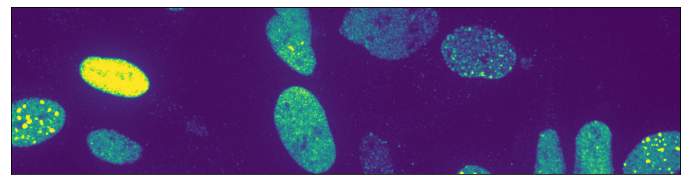

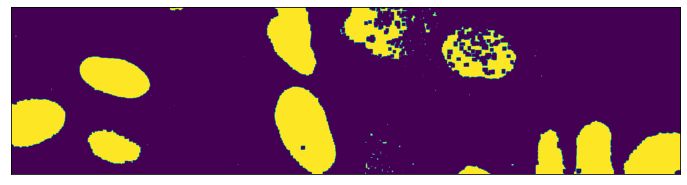

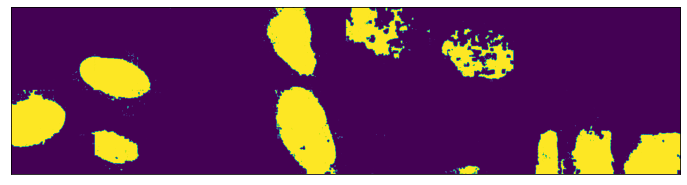

In [61]:
imgs= []
p =list(range(10,18)) + list(range(19, 27)) 
for img_dir in sorted(glob.glob('/n/holylfs/LABS/wadduwage_lab/Lab/uom_Udith/datasets/confocal/63xZseriesSmall_w1/val/*.png'))[:25]:
    if img_dir.split('_')[-1] in [f'{x}.png' for x in p]:
        print(img_dir)
        imgs.append(plt.imread(img_dir))
X= torch.from_numpy(np.array(imgs)).unsqueeze(dim=1).to(device)

Ht= modelH(m)
lambda_up, yt_down = modelA.compute_yt(X, Ht)
yt_up = decoder_upsample_net(yt_down, Ht= Ht)
X_hat = decoder(yt_up, Ht= Ht)

plt.figure(figsize= (12, 4))
a= X.cpu().detach().reshape(2,8,256,256).permute(0,2,1,3).flatten(start_dim=0, end_dim=1).flatten(start_dim=1, end_dim=2).numpy()
plt.xticks([])
plt.yticks([])
plt.imshow(a)
plt.savefig('cellSeg_img.png', dpi= 300)
plt.show()

plt.figure(figsize= (12, 4))
a= segment(X).cpu().detach().reshape(2,8,256,256).permute(0,2,1,3).flatten(start_dim=0, end_dim=1).flatten(start_dim=1, end_dim=2).numpy()
plt.xticks([])
plt.yticks([])
plt.imshow(a)
plt.savefig('cellSeg_gt.png', dpi= 300)
plt.show()

plt.figure(figsize= (12, 4))
a= X_hat.cpu().detach().reshape(2,8,256,256).permute(0,2,1,3).flatten(start_dim=0, end_dim=1).flatten(start_dim=1, end_dim=2).numpy()
plt.xticks([])
plt.yticks([])
plt.imshow(a)
plt.savefig('cellSeg_our.png', dpi= 300)
plt.show()


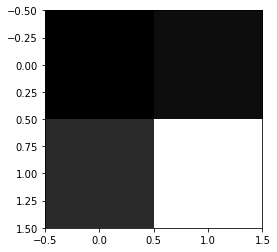

In [67]:
plt.imshow(yt_down[0,0].cpu().detach(), cmap= 'gray')